In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [43]:
df=pd.read_csv('learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [44]:
class DNN_4(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2):
        super(DNN_4, self).__init__()
        self.layer1 = nn.Linear(input_dim,32)
        self.layer2 = nn.Linear(32,16)
        self.layer3 = nn.Linear(16, 8)
        self.layer4 = nn.Linear(8, 4)
        self.output_layer = nn.Linear(4, 1)

        self.bn1=nn.BatchNorm1d(32)
        self.bn2=nn.BatchNorm1d(16)
        self.bn3=nn.BatchNorm1d(8)
        self.bn4=nn.BatchNorm1d(4)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.layer2(x)))
    

        x = torch.relu(self.bn3(self.layer3(x)))
        

        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout2(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [45]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

Optunaの設定

In [46]:
def objective(trial):
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整

    # モデル定義
    model = DNN_4(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >= 0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [47]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-12 21:01:26,262] A new study created in memory with name: no-name-5fb9ff3a-fa1e-4b31-b042-39f74b7059db
/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1287346/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:01:30,290] Trial 0 finished with value: 0.0 and parameters: {'dropout1': 0.5, 'dropout2': 0.25, 'learning_rate': 0.06979831322766003, 'weight_decay': 0.00022030040798636248}. Best is trial 0 with value: 0.0.


Early stopping at epoch 28
Final MCC: 0.0000


/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1287346/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:01:39,333] Trial 1 finished with value: 0.26393155162954324 and parameters: {'dropout1': 0.5, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0010811894298577965, 'weight_decay': 2.2695669000408336e-05}. Best is trial 1 with value: 0.26393155162954324.


Early stopping at epoch 65
Final MCC: 0.2639


/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1287346/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:01:43,248] Trial 2 finished with value: 0.0 and parameters: {'dropout1': 0.0, 'dropout2': 0.35000000000000003, 'learning_rate': 0.09731006603990339, 'weight_decay': 0.006907438852217143}. Best is trial 1 with value: 0.26393155162954324.


Early stopping at epoch 28
Final MCC: 0.0000


/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1287346/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:01:46,593] Trial 3 finished with value: 0.0 and parameters: {'dropout1': 0.25, 'dropout2': 0.05, 'learning_rate': 0.028406815533974457, 'weight_decay': 1.3140161802994002e-05}. Best is trial 1 with value: 0.26393155162954324.


Early stopping at epoch 23
Final MCC: 0.0000


/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1287346/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:01:50,147] Trial 4 finished with value: 0.1456710070440686 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.0, 'learning_rate': 0.0028371593927182612, 'weight_decay': 0.0004554902291477997}. Best is trial 1 with value: 0.26393155162954324.


Early stopping at epoch 25
Final MCC: 0.1457


/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1287346/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:02:00,697] Trial 5 finished with value: 0.21039247703903016 and parameters: {'dropout1': 0.0, 'dropout2': 0.05, 'learning_rate': 0.00017926803521533898, 'weight_decay': 0.0006996950232623845}. Best is trial 1 with value: 0.26393155162954324.


Early stopping at epoch 78
Final MCC: 0.2104


/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1287346/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:02:07,366] Trial 6 finished with value: 0.2960782006243549 and parameters: {'dropout1': 0.45, 'dropout2': 0.05, 'learning_rate': 0.0006804220122987877, 'weight_decay': 4.688645617043308e-05}. Best is trial 6 with value: 0.2960782006243549.
/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecate

Early stopping at epoch 48
Final MCC: 0.2961


[I 2024-12-12 21:02:07,653] Trial 8 pruned. 
[I 2024-12-12 21:02:07,802] Trial 9 pruned. 
[I 2024-12-12 21:02:07,973] Trial 10 pruned. 
[I 2024-12-12 21:02:12,640] Trial 11 finished with value: 0.2207176215537855 and parameters: {'dropout1': 0.4, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0008479326723042569, 'weight_decay': 5.30084079636327e-05}. Best is trial 6 with value: 0.2960782006243549.
/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1287346/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial

Early stopping at epoch 33
Final MCC: 0.2207


[I 2024-12-12 21:02:12,985] Trial 13 pruned. 
[I 2024-12-12 21:02:13,160] Trial 14 pruned. 
[I 2024-12-12 21:02:13,340] Trial 15 pruned. 
[I 2024-12-12 21:02:13,517] Trial 16 pruned. 
[I 2024-12-12 21:02:13,675] Trial 17 pruned. 
[I 2024-12-12 21:02:27,461] Trial 18 finished with value: 0.30067471043708344 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0003231468381727804, 'weight_decay': 0.0022185401764116186}. Best is trial 18 with value: 0.30067471043708344.
/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1287346/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See http

Final MCC: 0.3007


[I 2024-12-12 21:02:41,260] Trial 20 finished with value: 0.21151288413822708 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0003218799088170816, 'weight_decay': 0.0135948784685178}. Best is trial 18 with value: 0.30067471043708344.


Final MCC: 0.2115


/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1287346/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:02:48,403] Trial 21 finished with value: 0.24785466280049473 and parameters: {'dropout1': 0.45, 'dropout2': 0.2, 'learning_rate': 0.0014516510881440391, 'weight_decay': 0.0011837323422062348}. Best is trial 18 with value: 0.30067471043708344.
/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprec

Early stopping at epoch 51
Final MCC: 0.2479


[I 2024-12-12 21:03:00,008] Trial 23 finished with value: 0.19805367011493666 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.30000000000000004, 'learning_rate': 0.000494164820436562, 'weight_decay': 3.610235253414593e-05}. Best is trial 18 with value: 0.30067471043708344.


Early stopping at epoch 82
Final MCC: 0.1981


/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1287346/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:03:09,189] Trial 24 finished with value: 0.13015393292219313 and parameters: {'dropout1': 0.45, 'dropout2': 0.2, 'learning_rate': 0.0014547042579137984, 'weight_decay': 0.00013089042395572574}. Best is trial 18 with value: 0.30067471043708344.
/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been depre

Early stopping at epoch 67
Final MCC: 0.1302


[I 2024-12-12 21:03:21,630] Trial 26 finished with value: 0.1248747052940004 and parameters: {'dropout1': 0.5, 'dropout2': 0.1, 'learning_rate': 0.0005599876466636624, 'weight_decay': 0.0005187069253864659}. Best is trial 18 with value: 0.30067471043708344.
/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1287346/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:03:21,787] Trial 27 pruned. 


Early stopping at epoch 92
Final MCC: 0.1249


[I 2024-12-12 21:03:21,966] Trial 28 pruned. 
[I 2024-12-12 21:03:22,127] Trial 29 pruned. 
[I 2024-12-12 21:03:22,294] Trial 30 pruned. 
[I 2024-12-12 21:03:22,464] Trial 31 pruned. 
[I 2024-12-12 21:03:22,617] Trial 32 pruned. 
[I 2024-12-12 21:03:22,774] Trial 33 pruned. 
[I 2024-12-12 21:03:22,954] Trial 34 pruned. 
[I 2024-12-12 21:03:23,121] Trial 35 pruned. 
[I 2024-12-12 21:03:23,286] Trial 36 pruned. 
[I 2024-12-12 21:03:23,455] Trial 37 pruned. 
[I 2024-12-12 21:03:23,601] Trial 38 pruned. 
[I 2024-12-12 21:03:26,352] Trial 39 finished with value: 0.09767140275344749 and parameters: {'dropout1': 0.05, 'dropout2': 0.05, 'learning_rate': 0.003763312598274973, 'weight_decay': 0.003566871098741492}. Best is trial 18 with value: 0.30067471043708344.
/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True)

Early stopping at epoch 20
Final MCC: 0.0977


[I 2024-12-12 21:03:26,688] Trial 41 pruned. 
[I 2024-12-12 21:03:26,861] Trial 42 pruned. 
[I 2024-12-12 21:03:39,378] Trial 43 finished with value: 0.16469315538757745 and parameters: {'dropout1': 0.4, 'dropout2': 0.1, 'learning_rate': 0.00042436818988258307, 'weight_decay': 1.6123921196852643e-05}. Best is trial 18 with value: 0.30067471043708344.


Early stopping at epoch 93
Final MCC: 0.1647


/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1287346/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:03:53,068] Trial 44 finished with value: 0.33498928856029825 and parameters: {'dropout1': 0.45, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0001382136432164609, 'weight_decay': 4.6247960461665685e-05}. Best is trial 44 with value: 0.33498928856029825.
/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_logunifor

Final MCC: 0.3350


[I 2024-12-12 21:03:53,402] Trial 46 pruned. 
[I 2024-12-12 21:03:53,582] Trial 47 pruned. 
[I 2024-12-12 21:04:06,935] Trial 48 finished with value: 0.05084401709026159 and parameters: {'dropout1': 0.45, 'dropout2': 0.25, 'learning_rate': 0.0001002769466369391, 'weight_decay': 9.069786170544348e-05}. Best is trial 44 with value: 0.33498928856029825.
/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1287346/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲

Final MCC: 0.0508


[I 2024-12-12 21:04:07,268] Trial 50 pruned. 
[I 2024-12-12 21:04:07,448] Trial 51 pruned. 
[I 2024-12-12 21:04:07,599] Trial 52 pruned. 
[I 2024-12-12 21:04:07,764] Trial 53 pruned. 
[I 2024-12-12 21:04:07,931] Trial 54 pruned. 
[I 2024-12-12 21:04:08,115] Trial 55 pruned. 
[I 2024-12-12 21:04:08,291] Trial 56 pruned. 
[I 2024-12-12 21:04:08,461] Trial 57 pruned. 
[I 2024-12-12 21:04:21,632] Trial 58 finished with value: 0.08022147833741111 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.15000000000000002, 'learning_rate': 0.00042628874801915463, 'weight_decay': 1.1743599688160311e-05}. Best is trial 44 with value: 0.33498928856029825.
/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykerne

Early stopping at epoch 95
Final MCC: 0.0802


[I 2024-12-12 21:04:21,982] Trial 60 pruned. 
[I 2024-12-12 21:04:22,167] Trial 61 pruned. 
[I 2024-12-12 21:04:22,334] Trial 62 pruned. 
[I 2024-12-12 21:04:22,478] Trial 63 pruned. 
[I 2024-12-12 21:04:22,655] Trial 64 pruned. 
[I 2024-12-12 21:04:22,837] Trial 65 pruned. 
[I 2024-12-12 21:04:23,021] Trial 66 pruned. 
[I 2024-12-12 21:04:23,191] Trial 67 pruned. 
[I 2024-12-12 21:04:23,387] Trial 68 pruned. 
[I 2024-12-12 21:04:36,777] Trial 69 finished with value: 0.2065672005770008 and parameters: {'dropout1': 0.5, 'dropout2': 0.1, 'learning_rate': 0.000294347890557283, 'weight_decay': 0.0014821995667629168}. Best is trial 44 with value: 0.33498928856029825.
/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tm

Final MCC: 0.2066


[I 2024-12-12 21:04:37,120] Trial 71 pruned. 
[I 2024-12-12 21:04:37,304] Trial 72 pruned. 
[I 2024-12-12 21:04:50,587] Trial 73 finished with value: 0.2687201635824701 and parameters: {'dropout1': 0.1, 'dropout2': 0.15000000000000002, 'learning_rate': 0.00038264364284059163, 'weight_decay': 2.9840400224346613e-05}. Best is trial 44 with value: 0.33498928856029825.
/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1287346/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-

Final MCC: 0.2687


[I 2024-12-12 21:04:50,889] Trial 75 pruned. 
[I 2024-12-12 21:04:51,048] Trial 76 pruned. 
[I 2024-12-12 21:04:51,213] Trial 77 pruned. 
[I 2024-12-12 21:04:51,391] Trial 78 pruned. 
[I 2024-12-12 21:04:51,543] Trial 79 pruned. 
[I 2024-12-12 21:04:57,375] Trial 80 finished with value: 0.30841110709753766 and parameters: {'dropout1': 0.5, 'dropout2': 0.25, 'learning_rate': 0.0010035110465672654, 'weight_decay': 1.0349616115416644e-05}. Best is trial 44 with value: 0.33498928856029825.
/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1287346/2413154260.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

Early stopping at epoch 47
Final MCC: 0.3084


[I 2024-12-12 21:04:57,697] Trial 82 pruned. 
[I 2024-12-12 21:04:57,857] Trial 83 pruned. 
[I 2024-12-12 21:04:58,033] Trial 84 pruned. 
[I 2024-12-12 21:04:58,203] Trial 85 pruned. 
[I 2024-12-12 21:04:58,419] Trial 86 pruned. 
[I 2024-12-12 21:04:58,615] Trial 87 pruned. 
[I 2024-12-12 21:04:58,827] Trial 88 pruned. 
[I 2024-12-12 21:04:59,042] Trial 89 pruned. 
[I 2024-12-12 21:05:12,628] Trial 90 finished with value: 0.17049591384224672 and parameters: {'dropout1': 0.4, 'dropout2': 0.1, 'learning_rate': 0.00032530413480342277, 'weight_decay': 5.804233018144159e-05}. Best is trial 44 with value: 0.33498928856029825.
/tmp/ipykernel_1287346/2413154260.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1287346/2413154260.py:5: Future

Final MCC: 0.1705


[I 2024-12-12 21:05:12,944] Trial 92 pruned. 
[I 2024-12-12 21:05:13,071] Trial 93 pruned. 
[I 2024-12-12 21:05:13,253] Trial 94 pruned. 
[I 2024-12-12 21:05:13,410] Trial 95 pruned. 
[I 2024-12-12 21:05:13,577] Trial 96 pruned. 
[I 2024-12-12 21:05:13,724] Trial 97 pruned. 
[I 2024-12-12 21:05:13,890] Trial 98 pruned. 
[I 2024-12-12 21:05:14,046] Trial 99 pruned. 


Best Parameters:  {'dropout1': 0.45, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0001382136432164609, 'weight_decay': 4.6247960461665685e-05}
Best Validation F1:  0.33498928856029825


In [48]:
best_params = study.best_params

# JSON形式で保存
with open("optim_param/optim_DNN_4_params.json", "w") as f:
    json.dump(best_params, f)

print("Best parameters saved to 'best_params.json'")

Best parameters saved to 'best_params.json'


Epoch [1/150], Loss: 0.6896
Epoch [1/150], Train Loss: 0.6896, Val Loss: 0.7070
Epoch [2/150], Loss: 0.6829
Epoch [2/150], Train Loss: 0.6829, Val Loss: 0.6848
Epoch [3/150], Loss: 0.6826
Epoch [3/150], Train Loss: 0.6826, Val Loss: 0.6758
Epoch [4/150], Loss: 0.6726
Epoch [4/150], Train Loss: 0.6726, Val Loss: 0.6710
Epoch [5/150], Loss: 0.6705
Epoch [5/150], Train Loss: 0.6705, Val Loss: 0.6664
Epoch [6/150], Loss: 0.6652
Epoch [6/150], Train Loss: 0.6652, Val Loss: 0.6633
Epoch [7/150], Loss: 0.6578
Epoch [7/150], Train Loss: 0.6578, Val Loss: 0.6591
Epoch [8/150], Loss: 0.6580
Epoch [8/150], Train Loss: 0.6580, Val Loss: 0.6524
Epoch [9/150], Loss: 0.6528
Epoch [9/150], Train Loss: 0.6528, Val Loss: 0.6508
Epoch [10/150], Loss: 0.6484
Epoch [10/150], Train Loss: 0.6484, Val Loss: 0.6448
Epoch [11/150], Loss: 0.6458
Epoch [11/150], Train Loss: 0.6458, Val Loss: 0.6407
Epoch [12/150], Loss: 0.6423
Epoch [12/150], Train Loss: 0.6423, Val Loss: 0.6409
Epoch [13/150], Loss: 0.6411
Epoch

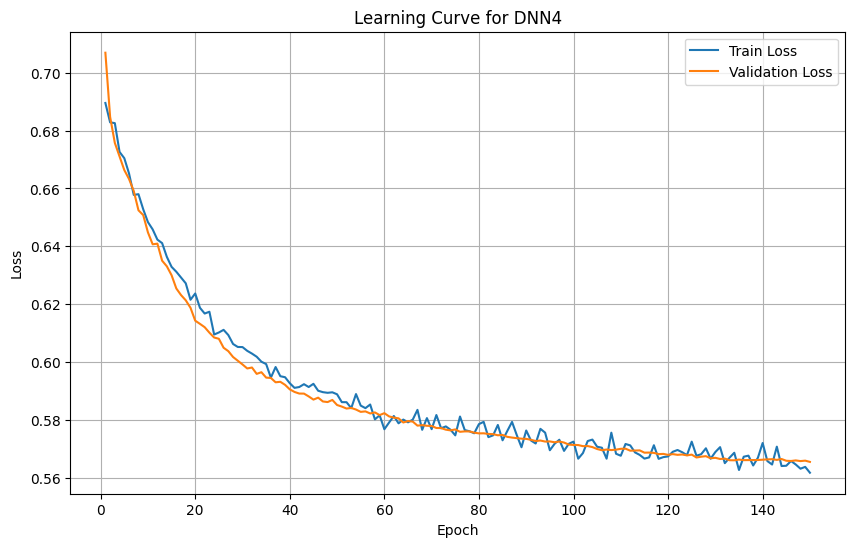

In [55]:
best_params=study.best_params
model = DNN_4(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"]).to(device)


# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=150
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN4')
plt.legend()
plt.grid()
plt.show()

Accuracy: 57.86%
Precision: 0.4756
Recall: 0.8909
F1 Score: 0.6201
Matthews Correlation Coefficient: 0.2971
Specificity: 0.3822


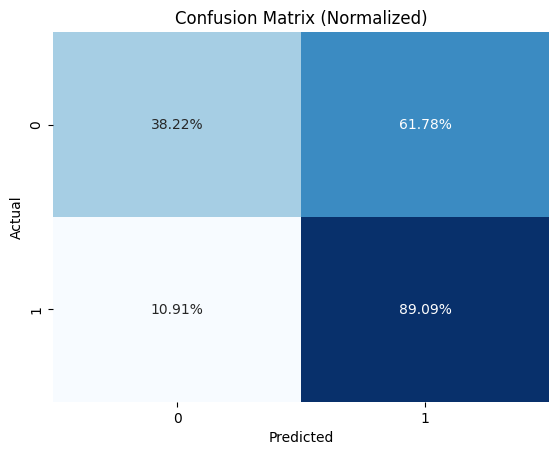

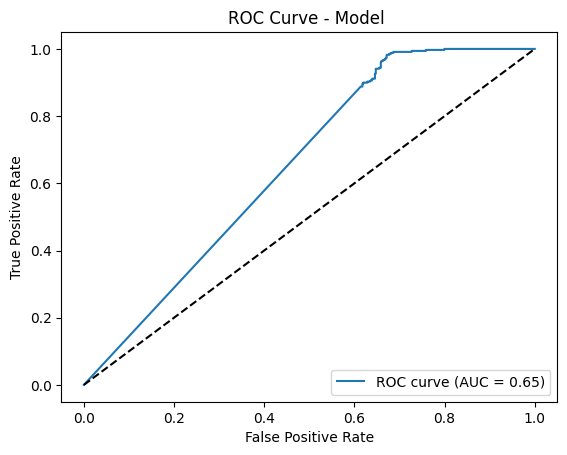

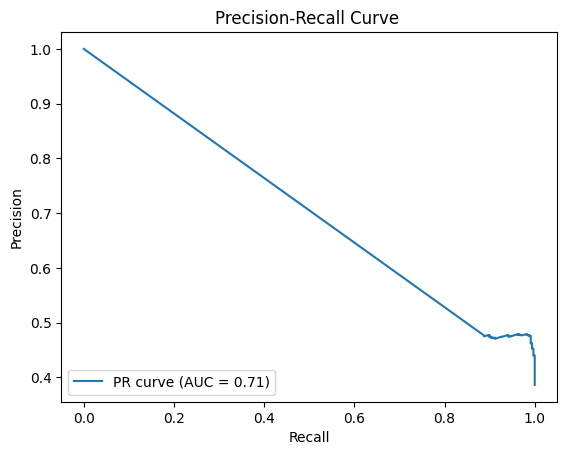

In [56]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >=0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [51]:
# モデルと構造を保存
torch.save(model.state_dict(), 'model_params/DNN_4.pth')



In [52]:
from torchsummary import summary
summary(model, input_size=(X_train_tensor.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             960
       BatchNorm1d-2                   [-1, 32]              64
           Dropout-3                   [-1, 32]               0
            Linear-4                   [-1, 16]             528
       BatchNorm1d-5                   [-1, 16]              32
            Linear-6                    [-1, 8]             136
       BatchNorm1d-7                    [-1, 8]              16
            Linear-8                    [-1, 4]              36
       BatchNorm1d-9                    [-1, 4]               8
          Dropout-10                    [-1, 4]               0
           Linear-11                    [-1, 1]               5
Total params: 1,785
Trainable params: 1,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back